In [1]:
import pandas as pd
import requests
import numpy as np

# use geopandas for neighborhood boundaries treatment
import geopandas as gpd
from shapely.geometry import shape
import json

# plotting library
import folium 

# settings
pd.set_option('display.max_rows', 150)

## Toronto neighborhood data
Official Toronto Neighhbourhood data from https://open.toronto.ca/dataset/neighbourhoods/

In [2]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()
#print(package["result"]["resources"])
 
# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:
 
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"],
              "limit": 150 }
        data = requests.get(url, params = p).json()
        df_toronto_neighborhood_raw = pd.DataFrame(data["result"]["records"])
        break
print(df_toronto_neighborhood_raw.shape)
df_toronto_neighborhood_raw.head()


(140, 18)


_id  AREA_ID  AREA_ATTR_ID PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0  9801  2480141      26005521           None             096            096   
1  9802  2480140      26005520           None             095            095   
2  9803  2480139      26005519           None             109            109   
3  9804  2480064      26005444           None             064            064   
4  9805  2480063      26005443           None             103            103   

                   AREA_NAME                  AREA_DESC     X     Y LONGITUDE  \
0             Casa Loma (96)             Casa Loma (96)  None  None      None   
1                 Annex (95)                 Annex (95)  None  None      None   
2   Caledonia-Fairbank (109)   Caledonia-Fairbank (109)  None  None      None   
3     Woodbine Corridor (64)     Woodbine Corridor (64)  None  None      None   
4  Lawrence Park South (103)  Lawrence Park South (103)  None  None      None   

  LATITUDE  OBJECTID   Shape__Area  Shape__Length  \
0     None  17545105  3.678385e+06    8214.176485   
1     None  17545121  5.337192e+06   10513.883143   
2     None  17545137  2.955857e+06    6849.911724   
3     None  17545153  3.052518e+06    7512.966773   
4     None  17545169  6.211341e+06   13530.370002   

                                            geometry CLASSIFICATION  \
0  {"type": "Polygon", "coordinates": [[[-79.4146...           None   
1  {"type": "Polygon", "coordinates": [[[-79.3941...           None   
2  {"type": "Polygon", "coordinates": [[[-79.4602...           None   
3  {"type": "Polygon", "coordinates": [[[-79.3148...           None   
4  {"type": "Polygon", "coordinates": [[[-79.4109...           None   

  CLASSIFICATION_CODE  
0                None  
1                None  
2                None  
3                None  
4                None

### Data cleaning
Get neighborhood names, sorted alphabetically \
Rename column name and extract neighborhood number

In [3]:
df_toronto_neighborhood = pd.DataFrame(df_toronto_neighborhood_raw[['AREA_NAME', 'geometry']])
df_toronto_neighborhood = df_toronto_neighborhood.sort_values(by = ['AREA_NAME']).reset_index(drop = True)

# extract neighborhood number
df_toronto_neighborhood = df_toronto_neighborhood.rename(columns={'AREA_NAME':'neighborhood'})
df_toronto_neighborhood.insert(1,column='neighborhood number', value='')
for index, value in df_toronto_neighborhood['neighborhood'].items():
    n_list = value.split()
    neighborhood_name = ' '.join(n_list[0:-1])
    neighborhood_number = n_list[-1].strip('()')
    
    df_toronto_neighborhood['neighborhood'][index] = neighborhood_name
    df_toronto_neighborhood['neighborhood number'][index] = neighborhood_number
    
# treatment of 'Mimico'
df_toronto_neighborhood.loc[df_toronto_neighborhood['neighborhood'].str.contains('Mimico'), 'neighborhood'] = 'Mimico'
df_toronto_neighborhood.head()

neighborhood neighborhood number  \
0               Agincourt North                 129   
1  Agincourt South-Malvern West                 128   
2                     Alderwood                  20   
3                         Annex                  95   
4             Banbury-Don Mills                  42   

                                            geometry  
0  {"type": "Polygon", "coordinates": [[[-79.2421...  
1  {"type": "Polygon", "coordinates": [[[-79.2549...  
2  {"type": "Polygon", "coordinates": [[[-79.5486...  
3  {"type": "Polygon", "coordinates": [[[-79.3941...  
4  {"type": "Polygon", "coordinates": [[[-79.3305...

### Get latitude and longitude coordinates of each neighborhood by getting the centers of polygons

In [4]:
poly_list = [shape(json.loads(i)) for i in df_toronto_neighborhood['geometry'].tolist()]
gdf_toronto_neighborhood = gpd.GeoDataFrame(df_toronto_neighborhood, geometry=poly_list)
gdf_toronto_neighborhood.head()

neighborhood neighborhood number  \
0               Agincourt North                 129   
1  Agincourt South-Malvern West                 128   
2                     Alderwood                  20   
3                         Annex                  95   
4             Banbury-Don Mills                  42   

                                            geometry  
0  POLYGON ((-79.24213 43.80247, -79.24319 43.802...  
1  POLYGON ((-79.25498 43.78122, -79.25797 43.780...  
2  POLYGON ((-79.54866 43.59022, -79.54876 43.590...  
3  POLYGON ((-79.39414 43.66872, -79.39588 43.668...  
4  POLYGON ((-79.33055 43.73979, -79.33044 43.739...

In [5]:
# get centeroids
df_toronto_neighborhood['centroids'] = gdf_toronto_neighborhood.centroid
df_toronto_neighborhood.head()

neighborhood neighborhood number  \
0               Agincourt North                 129   
1  Agincourt South-Malvern West                 128   
2                     Alderwood                  20   
3                         Annex                  95   
4             Banbury-Don Mills                  42   

                                            geometry  \
0  POLYGON ((-79.24213 43.80247, -79.24319 43.802...   
1  POLYGON ((-79.25498 43.78122, -79.25797 43.780...   
2  POLYGON ((-79.54866 43.59022, -79.54876 43.590...   
3  POLYGON ((-79.39414 43.66872, -79.39588 43.668...   
4  POLYGON ((-79.33055 43.73979, -79.33044 43.739...   

                    centroids  
0  POINT (-79.26671 43.80544)  
1  POINT (-79.26561 43.78866)  
2  POINT (-79.54161 43.60494)  
3  POINT (-79.40400 43.67159)  
4  POINT (-79.34972 43.73766)

### Let's plot the neighborhood location and their boundaries.
The boundaries geojson data is obtained from https://open.toronto.ca/dataset/neighbourhoods/

In [6]:
# Toronto longitude and latitude
lat_toronto = 43.7032
lng_toronto = -79.3832


In [7]:
map_toronto = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True, zoom_start=11)

# draw boundaries of neighborhoods
folium.Choropleth(
    geo_data='Neighbourhoods.geojson',
    fill_color='YlGn',
    fill_opacity=0,
    line_color='#e0811b',
    line_opacity=0.9
    ).add_to(map_toronto)

# add markers of neighborhood to map
for center, neighborhood in zip(df_toronto_neighborhood['centroids'], df_toronto_neighborhood['neighborhood']):
    lat = center.y
    lng = center.x
    label = neighborhood
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color='#1f5682',
        weight=1.5,
        fill=True,
        fill_color='#3395db',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto

## Toronto Property Listing Price, 2020
Data scraped from https://toronto.listing.ca/

Data cleaning

In [8]:
# read csv
df_prop_price_2020 = pd.read_csv('../data/Toronto_real_estate_price_1.csv')
# clean up price column
df_prop_price_2020['average_property_price'] = df_prop_price_2020['average_property_price'].str.strip()
df_prop_price_2020['average_property_price'] = df_prop_price_2020['average_property_price'].str.strip('$')
df_prop_price_2020['average_property_price'] = df_prop_price_2020['average_property_price'].str.replace(',','')
df_prop_price_2020['average_property_price'] = pd.to_numeric(df_prop_price_2020['average_property_price'])
# sort by neighborhood
df_prop_price_2020 = df_prop_price_2020.sort_values(by = ['neighborhood']).reset_index(drop = True)
df_prop_price_2020.head()

neighborhood  average_property_price
0               Agincourt North                  743723
1  Agincourt South-Malvern West                  826768
2                     Alderwood                  835439
3                         Annex                 1971720
4             Banbury-Don Mills                 1339160

In [9]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [10]:
# combine splitted neighborhood
tmp = ''
tmp_price = 0
rmv_list = []
for index, row in df_prop_price_2020.iterrows():
    # splitted neighborhood -> rename to duplicate
    if hasNumbers(row['neighborhood']):
        str_list = row['neighborhood'].split(' ')[0:-1]
        neighbor_name = ' '.join(str_list)
        df_prop_price_2020.loc[index, 'neighborhood'] = neighbor_name
    else:
        neighbor_name = row['neighborhood']
    # duplicated
    if neighbor_name != tmp:
        tmp = neighbor_name
        tmp_price = row['average_property_price']
    else:
        # calculate average
        df_prop_price_2020.loc[index, 'average_property_price'] = (row['average_property_price'] + tmp_price) / 2
        rmv_list.append(index - 1)
print(rmv_list)
df_prop_price_2020.drop(rmv_list, inplace=True)
df_prop_price_2020 = df_prop_price_2020.reset_index(drop=True)
print(df_prop_price_2020.shape)
# replace "Crescent Town" with "Taylor-Massey"
df_prop_price_2020.replace({'neighborhood': 'Crescent Town'}, 'Taylor-Massey', inplace=True)
# "East York" -> "Old East York"
df_prop_price_2020.replace({'neighborhood': 'East York'}, 'Old East York', inplace=True)
# "Humberlea-Pelmo Park" -> "Pelmo Park-Humberlea"
df_prop_price_2020.replace({'neighborhood': 'Humberlea-Pelmo Park'}, 'Pelmo Park-Humberlea', inplace=True)
# sort
df_prop_price_2020 = df_prop_price_2020.sort_values(by = ['neighborhood']).reset_index(drop = True)
df_prop_price_2020.head()

[57, 69, 95, 109, 119, 127]
(140, 2)


neighborhood  average_property_price
0               Agincourt North                743723.0
1  Agincourt South-Malvern West                826768.0
2                     Alderwood                835439.0
3                         Annex               1971720.0
4             Banbury-Don Mills               1339160.0

In [11]:
# combine dataframes
df_toronto_prop_price = pd.concat([df_toronto_neighborhood, df_prop_price_2020['average_property_price']], axis=1)
df_toronto_prop_price['name_with_id'] = ''
for i in range(df_toronto_prop_price.shape[0]):
    if df_toronto_prop_price.loc[i, 'neighborhood'] != 'Mimico':
        df_toronto_prop_price.loc[i, 'name_with_id'] = '{0} ({1})'.format(
            df_toronto_prop_price.loc[i, 'neighborhood'], 
            df_toronto_prop_price.loc[i, 'neighborhood number'])
    else:
        df_toronto_prop_price.loc[i, 'name_with_id'] = '{0} ({1})'.format(
            'Mimico (includes Humber Bay Shores)', 
            df_toronto_prop_price.loc[i, 'neighborhood number'])
        
df_toronto_prop_price.head()

neighborhood neighborhood number  \
0               Agincourt North                 129   
1  Agincourt South-Malvern West                 128   
2                     Alderwood                  20   
3                         Annex                  95   
4             Banbury-Don Mills                  42   

                                            geometry  \
0  POLYGON ((-79.24213 43.80247, -79.24319 43.802...   
1  POLYGON ((-79.25498 43.78122, -79.25797 43.780...   
2  POLYGON ((-79.54866 43.59022, -79.54876 43.590...   
3  POLYGON ((-79.39414 43.66872, -79.39588 43.668...   
4  POLYGON ((-79.33055 43.73979, -79.33044 43.739...   

                    centroids  average_property_price  \
0  POINT (-79.26671 43.80544)                743723.0   
1  POINT (-79.26561 43.78866)                826768.0   
2  POINT (-79.54161 43.60494)                835439.0   
3  POINT (-79.40400 43.67159)               1971720.0   
4  POINT (-79.34972 43.73766)               1339160.0   

                         name_with_id  
0               Agincourt North (129)  
1  Agincourt South-Malvern West (128)  
2                      Alderwood (20)  
3                          Annex (95)  
4              Banbury-Don Mills (42)

## Plot choropleth of neighborhood price

In [12]:
# plot on map
map_toronto_prop = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True, zoom_start=11)

# draw boundaries of neighborhoods
folium.Choropleth(
    geo_data='Neighbourhoods.geojson',
    data=df_toronto_prop_price,
    columns=['name_with_id', 'average_property_price'],
    key_on='feature.properties.AREA_NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.8,
    legend_name='Average Property Price (CAD)',
    smooth_factor=0
    ).add_to(map_toronto_prop)

map_toronto_prop

## Analysis neighborhood venues

In [14]:
# set up Foursquares credentials
CLIENT_ID = 'I4LBVKARVALYGZU3ZG23MGRTLVSJHTGJ1FOOTB3CHIQZTIK4' # your Foursquare ID
CLIENT_SECRET = 'UTRGZAVVPGRADQBFK3QFHF4PAIHUW0GUVR4CCJ4PR3TB0GLR' # your Foursquare Secret
VERSION = '20201201' # Foursquare API version, use 2020 version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I4LBVKARVALYGZU3ZG23MGRTLVSJHTGJ1FOOTB3CHIQZTIK4
CLIENT_SECRET:UTRGZAVVPGRADQBFK3QFHF4PAIHUW0GUVR4CCJ4PR3TB0GLR


### Define function to get venue of a location

In [15]:
def getNearbyVenues(names, centroids, radius=500):
    
    venues_list = []
    no_venue_neighborhoods = []
    cnt = 0    
    for name, center in zip(names, centroids):
        lat = center.y
        lng = center.x
        #print(name)
        cnt += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) == 0:
            no_venue_neighborhoods.append(name)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print('Retrieved nearby venues of {}, {}/{} completed!                                                              '
                  .format(name, cnt, names.size), end='\r', flush=True)
        
    # report zero venue neighborhoods
    print('\nThe following neighborhoods has 0 venue within the radius of {} m'.format(radius))
    for z_neighbor in no_venue_neighborhoods:
        print(z_neighbor)
    
    # assemble dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get nearby venues of each neighborhood

In [31]:
toronto_venues = getNearbyVenues(names=df_toronto_prop_price['neighborhood'],
                                   centroids=df_toronto_prop_price['centroids'],
                                   radius=1000 )


Retrieved nearby venues of Yorkdale-Glen Park, 140/140 completed!                                                                              
The following neighborhoods has 0 venue within the radius of 1000 m


In [32]:
# check the size of resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(5656, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Agincourt North              43.805441              -79.266712   
1  Agincourt North              43.805441              -79.266712   
2  Agincourt North              43.805441              -79.266712   
3  Agincourt North              43.805441              -79.266712   
4  Agincourt North              43.805441              -79.266712   

                                       Venue  Venue Latitude  Venue Longitude  \
0                                  Menchie's       43.808338       -79.268288   
1   Saravanaa Bhavan South Indian Restaurant       43.810117       -79.269275   
2           Samosa King - Embassy Restaurant       43.810152       -79.257316   
3                              Booster Juice       43.809915       -79.269382   
4  Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮)       43.797885       -79.270585   

       Venue Category  
0  Frozen Yogurt Shop  
1   Indian Restaurant  
2   Indian Restaurant  
3           Juice Bar  
4  Chinese Restaurant

### Check how many venues for each neighborhood

In [33]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                 
Agincourt North                                         45   
Agincourt South-Malvern West                            44   
Alderwood                                               22   
Annex                                                  100   
Banbury-Don Mills                                       45   
Bathurst Manor                                          12   
Bay Street Corridor                                    100   
Bayview Village                                         24   
Bayview Woods-Steeles                                   15   
Bedford Park-Nortown                                    48   
Beechborough-Greenbrook                                 17   
Bendale                                                 16   
Birchcliffe-Cliffside                                   14   
Black Creek                                             13   
Blake-Jones                                            100   
Briar Hill-Belgravia                                    39   
Bridle Path-Sunnybrook-York Mills                        9   
Broadview North                                         35   
Brookhaven-Amesbury                                     19   
Cabbagetown-South St.James Town                         36   
Caledonia-Fairbank                                      27   
Casa Loma                                               83   
Centennial Scarborough                                   5   
Church-Yonge Corridor                                  100   
Clairlea-Birchmount                                     13   
Clanton Park                                            15   
Cliffcrest                                              12   
Corso Italia-Davenport                                  50   
Danforth                                                65   
Danforth East York                                      58   
Don Valley Village                                      64   
Dorset Park                                             32   
Dovercourt-Wallace Emerson-Junction                    100   
Downsview-Roding-CFB                                     9   
Dufferin Grove                                          41   
East End-Danforth                                       59   
Edenbridge-Humber Valley                                10   
Eglinton East                                           15   
Elms-Old Rexdale                                         9   
Englemount-Lawrence                                     28   
Eringate-Centennial-West Deane                          26   
Etobicoke West Mall                                     26   
Flemingdon Park                                         32   
Forest Hill North                                       24   
Forest Hill South                                       33   
Glenfield-Jane Heights                                  11   
Greenwood-Coxwell                                       57   
Guildwood                                               13   
Henry Farm                                              77   
High Park North                                         90   
High Park-Swansea                                       57   
Highland Creek                                           6   
Hillcrest Village                                       21   
Humber Heights-Westmount                                22   
Humber Summit                                            7   
Humbermede                                              19   
Humewood-Cedarvale                                      18   
Ionview                                                 24   
Islington-City Centre West                              58   
Junction Area                                          100   
Keelesdale-Eglinton West                                27   
Kennedy Park                                            20   
Kensington-Chinatown                                   100   
Kingsvi

In [34]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 349 uniques categories.


### Drop 'Neighborhood' venues

In [35]:
toronto_venues[toronto_venues['Venue Category']=='Neighborhood']

Neighborhood  Neighborhood Latitude  \
280                 Bay Street Corridor              43.657512   
696                     Broadview North              43.688825   
926               Church-Yonge Corridor              43.659650   
1994                     Highland Creek              43.790775   
2415               Kensington-Chinatown              43.653554   
2592                Lawrence Park North              43.730060   
2633                Lawrence Park South              43.717212   
3449                    North Riverdale              43.671995   
3980                        Regent Park              43.659992   
4144                Rosedale-Moore Park              43.682821   
4314                     South Parkdale              43.636699   
4830  Waterfront Communities-The Island              43.633881   
5566                     Yonge-St.Clair              43.687859   

      Neighborhood Longitude                          Venue  Venue Latitude  \
280               -79.385722               Downtown Toronto       43.653232   
696               -79.355629  The Governor's Bridge Lookout       43.685070   
926               -79.379018               Downtown Toronto       43.653232   
1994              -79.177472                 Highland Creek       43.790281   
2415              -79.397240               Downtown Toronto       43.653232   
2592              -79.403978                   Bedford Park       43.725188   
2633              -79.406038                   Bedford Park       43.725188   
3449              -79.351260                 East Chinatown       43.665678   
3980              -79.360509                 East Chinatown       43.665678   
4144              -79.379670                     Summerhill       43.682976   
4314              -79.439338                       Parkdale       43.640524   
4830              -79.377201                   Harbourfront       43.639526   
5566              -79.397871                     Summerhill       43.682976   

      Venue Longitude Venue Category  
280        -79.385296   Neighborhood  
696        -79.366661   Neighborhood  
926        -79.385296   Neighborhood  
1994       -79.173703   Neighborhood  
2415       -79.385296   Neighborhood  
2592       -79.408463   Neighborhood  
2633       -79.408463   Neighborhood  
3449       -79.351668   Neighborhood  
3980       -79.351668   Neighborhood  
4144       -79.389123   Neighborhood  
4314       -79.432200   Neighborhood  
4830       -79.380688   Neighborhood  
5566       -79.389123   Neighborhood

In [36]:
# drop neighborhood venues
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.shape

There are 348 uniques categories.


(5643, 7)

### Analyze Neighborhoods

In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(5643, 349)


Neighborhood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Agincourt North    0                  0               0                  0   
1  Agincourt North    0                  0               0                  0   
2  Agincourt North    0                  0               0                  0   
3  Agincourt North    0                  0               0                  0   
4  Agincourt North    0                  0               0                  0   

   African Restaurant  American Restaurant  Amphitheater  Animal Shelter  \
0                   0                    0             0               0   
1                   0                    0             0               0   
2                   0                    0             0               0   
3                   0                    0             0               0   
4                   0                    0             0               0   

   Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  Whisky Bar  \
0             0  ...                      0                0           0   
1             0  ...                      0                0           0   
2             0  ...                      0                0           0   
3             0  ...                      0                0           0   
4             0  ...                      0                0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0            0              0            0    0   
1         0          0            0              0            0    0   
2         0          0            0              0            0    0   
3         0          0            0              0            0    0   
4         0          0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 349 columns]

### Group rows by neighborhood and take the mean of the occurance of each category

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0               Agincourt North  0.0                0.0             0.0   
1  Agincourt South-Malvern West  0.0                0.0             0.0   
2                     Alderwood  0.0                0.0             0.0   
3                         Annex  0.0                0.0             0.0   
4             Banbury-Don Mills  0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Amphitheater  \
0                0.0                 0.0             0.000000           0.0   
1                0.0                 0.0             0.022727           0.0   
2                0.0                 0.0             0.000000           0.0   
3                0.0                 0.0             0.000000           0.0   
4                0.0                 0.0             0.022222           0.0   

   Animal Shelter  Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  \
0             0.0           0.0  ...               0.044444              0.0   
1             0.0           0.0  ...               0.000000              0.0   
2             0.0           0.0  ...               0.000000              0.0   
3             0.0           0.0  ...               0.000000              0.0   
4             0.0           0.0  ...               0.000000              0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0         0.0       0.0        0.0     0.022222       0.000000          0.0   
1         0.0       0.0        0.0     0.000000       0.000000          0.0   
2         0.0       0.0        0.0     0.000000       0.000000          0.0   
3         0.0       0.0        0.0     0.000000       0.000000          0.0   
4         0.0       0.0        0.0     0.000000       0.044444          0.0   

   Zoo  Zoo Exhibit  
0  0.0          0.0  
1  0.0          0.0  
2  0.0          0.0  
3  0.0          0.0  
4  0.0          0.0  

[5 rows x 349 columns]

### Get top 10 most common venues for each neighborhood

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']        

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North    Chinese Restaurant                Bakery   
1  Agincourt South-Malvern West    Chinese Restaurant  Cantonese Restaurant   
2                     Alderwood           Gas Station           Pizza Place   
3                         Annex           Coffee Shop    Italian Restaurant   
4             Banbury-Don Mills            Restaurant           Coffee Shop   
5                Bathurst Manor                  Park         Grocery Store   
6           Bay Street Corridor           Coffee Shop                  Café   
7               Bayview Village                  Park              Pharmacy   
8         Bayview Woods-Steeles                  Park                  Bank   
9          Bedford Park-Nortown           Pizza Place    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
0           Pizza Place           Coffee Shop       Indian Restaurant   
1            Restaurant         Shopping Mall            Intersection   
2                  Park        Discount Store              Print Shop   
3                  Café            Restaurant                  Bakery   
4   Japanese Restaurant                  Café           Women's Store   
5        Hardware Store        Breakfast Spot  Furniture / Home Store   
6                  Park                 Hotel          Clothing Store   
7  Fast Food Restaurant        Sandwich Place          Clothing Store   
8                  Pool                  Café          Sandwich Place   
9           Coffee Shop             Pet Store                    Bank   

   6th Most Common Venue          7th Most Common Venue  \
0  Vietnamese Restaurant                 Sandwich Place   
1       Asian Restaurant       Mediterranean Restaurant   
2               Pharmacy               Storage Facility   
3          Grocery Store  Vegetarian / Vegan Restaurant   
4            Pizza Place                           Bank   
5            Men's Store                      Nightclub   
6       Department Store                          Plaza   
7           Burger Joint                    Coffee Shop   
8            Coffee Shop                   Liquor Store   
9       Sushi Restaurant                     Bagel Shop   

    8th Most Common Venue 9th Most Common Venue     10th Most Common Venue  
0                    Bank        Discount Store                   Pharmacy  
1             Supermarket     Korean Restaurant  Latin American Restaurant  
2            Skating Rink         Grocery Store                        Gym  
3               Bookstore   Japanese Restaurant                   Boutique  
4          Baseball Field              Pharmacy              Grocery Store  
5          Baseball Field            Sports Bar                 Playground  
6  Furniture / Home Store       Bubble Tea Shop        Japanese Restaurant  
7                   Trail                  Bank              Metro Station  
8     Japanese Restaurant           Gas Station         Chinese Restaurant  
9          Sandwich Place           Bridal Shop                Sports Club

### Cluster neighborhoods

In [41]:
# import libraries
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [42]:
# dataframe for clustering
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

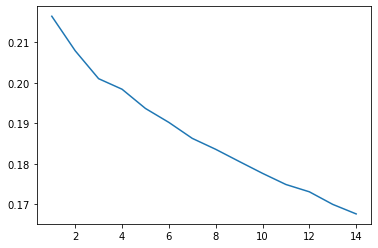

In [43]:
# elbow analysis
distortion = []
inertia = []
for k in range(1,15):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortion.append(sum(np.min(cdist(toronto_grouped_clustering, kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0])
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1,15), distortion)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

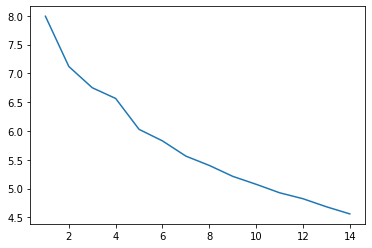

In [44]:
plt.plot(range(1,15), inertia)

### Use k=3 for clustering

In [45]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

Cluster Labels                  Neighborhood 1st Most Common Venue  \
0               0               Agincourt North    Chinese Restaurant   
1               2  Agincourt South-Malvern West    Chinese Restaurant   
2               0                     Alderwood           Gas Station   
3               2                         Annex           Coffee Shop   
4               2             Banbury-Don Mills            Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery           Pizza Place           Coffee Shop   
1  Cantonese Restaurant            Restaurant         Shopping Mall   
2           Pizza Place                  Park        Discount Store   
3    Italian Restaurant                  Café            Restaurant   
4           Coffee Shop   Japanese Restaurant                  Café   

  5th Most Common Venue  6th Most Common Venue          7th Most Common Venue  \
0     Indian Restaurant  Vietnamese Restaurant                 Sandwich Place   
1          Intersection       Asian Restaurant       Mediterranean Restaurant   
2            Print Shop               Pharmacy               Storage Facility   
3                Bakery          Grocery Store  Vegetarian / Vegan Restaurant   
4         Women's Store            Pizza Place                           Bank   

  8th Most Common Venue 9th Most Common Venue     10th Most Common Venue  
0                  Bank        Discount Store                   Pharmacy  
1           Supermarket     Korean Restaurant  Latin American Restaurant  
2          Skating Rink         Grocery Store                        Gym  
3             Bookstore   Japanese Restaurant                   Boutique  
4        Baseball Field              Pharmacy              Grocery Store

### Create a new dataframe including the cluster and top 10 venues for each neighborhood

In [46]:
toronto_merged = df_toronto_prop_price

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

toronto_merged.head(10)

neighborhood neighborhood number  \
0               Agincourt North                 129   
1  Agincourt South-Malvern West                 128   
2                     Alderwood                  20   
3                         Annex                  95   
4             Banbury-Don Mills                  42   
5                Bathurst Manor                  34   
6           Bay Street Corridor                  76   
7               Bayview Village                  52   
8         Bayview Woods-Steeles                  49   
9          Bedford Park-Nortown                  39   

                                            geometry  \
0  POLYGON ((-79.24213 43.80247, -79.24319 43.802...   
1  POLYGON ((-79.25498 43.78122, -79.25797 43.780...   
2  POLYGON ((-79.54866 43.59022, -79.54876 43.590...   
3  POLYGON ((-79.39414 43.66872, -79.39588 43.668...   
4  POLYGON ((-79.33055 43.73979, -79.33044 43.739...   
5  POLYGON ((-79.43998 43.76156, -79.43967 43.761...   
6  POLYGON ((-79.38752 43.65067, -79.38663 43.650...   
7  POLYGON ((-79.35966 43.76649, -79.36014 43.766...   
8  POLYGON ((-79.39623 43.80327, -79.39443 43.803...   
9  POLYGON ((-79.40493 43.73601, -79.40503 43.735...   

                    centroids  average_property_price  \
0  POINT (-79.26671 43.80544)                743723.0   
1  POINT (-79.26561 43.78866)                826768.0   
2  POINT (-79.54161 43.60494)                835439.0   
3  POINT (-79.40400 43.67159)               1971720.0   
4  POINT (-79.34972 43.73766)               1339160.0   
5  POINT (-79.45606 43.76481)                967230.0   
6  POINT (-79.38572 43.65751)               2138757.0   
7  POINT (-79.37712 43.77636)               1499543.0   
8  POINT (-79.38212 43.79680)               1091276.0   
9  POINT (-79.42023 43.73149)               1562765.0   

                         name_with_id  Cluster Labels 1st Most Common Venue  \
0               Agincourt North (129)               0    Chinese Restaurant   
1  Agincourt South-Malvern West (128)               2    Chinese Restaurant   
2                      Alderwood (20)               0           Gas Station   
3                          Annex (95)               2           Coffee Shop   
4              Banbury-Don Mills (42)               2            Restaurant   
5                 Bathurst Manor (34)               1                  Park   
6            Bay Street Corridor (76)               2           Coffee Shop   
7                Bayview Village (52)               0                  Park   
8          Bayview Woods-Steeles (49)               1                  Park   
9           Bedford Park-Nortown (39)               2           Pizza Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery           Pizza Place           Coffee Shop   
1  Cantonese Restaurant            Restaurant         Shopping Mall   
2           Pizza Place                  Park        Discount Store   
3    Italian Restaurant                  Café            Restaurant   
4           Coffee Shop   Japanese Restaurant                  Café   
5         Grocery Store        Hardware Store        Breakfast Spot   
6                  Café                  Park                 Hotel   
7              Pharmacy  Fast Food Restaurant        Sandwich Place   
8                  Bank                  Pool                  Café   
9    Italian Restaurant           Coffee Shop             Pet Store   

    5th Most Common Venue  6th Most Common Venue  \
0       Indian Restaurant  Vietnamese Restaurant   
1            Intersection       Asian Restaurant   
2              Print Shop               Pharmacy   
3                  Bakery          Grocery Store   
4           Women's Store            Pizza Place   
5  Furniture / Home Store            Men's Store   
6          Clothing Store       Department Store   
7          Clothing Store           Burger Joint   
8          Sandwich Place            Coffee Shop

### Visualize cluster

In [47]:
map_toronto_clusters = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.get_cmap('tab10').colors
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for center, poi, cluster in zip(toronto_merged['centroids'], toronto_merged['neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    lat = center.y
    lng = center.x
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1.5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters

### Overlay choorpleth and clustering result

In [48]:
map_toronto_clusters_prop = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True, zoom_start=11)

# property price
folium.Choropleth(
    geo_data='Neighbourhoods.geojson',
    data=df_toronto_prop_price,
    columns=['name_with_id', 'average_property_price'],
    key_on='feature.properties.AREA_NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.8,
    legend_name='Average Property Price (CAD)',
    smooth_factor=0
    ).add_to(map_toronto_clusters_prop)

# add markers to the map
for center, poi, cluster in zip(toronto_merged['centroids'], toronto_merged['neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    lat = center.y
    lng = center.x
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1.5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_toronto_clusters_prop)
       
map_toronto_clusters_prop

### Analyze clusters to create cluster labels
Check top 3 common venues

In [102]:
common_venues = [{} for i in range (3)]

for i in range(toronto_merged.shape[0]):
    cluster = toronto_merged.loc[i, 'Cluster Labels']
    venue_1st = toronto_merged.loc[i, '1st Most Common Venue']
    venue_2nd = toronto_merged.loc[i, '2nd Most Common Venue']
    venue_3rd = toronto_merged.loc[i, '3rd Most Common Venue']
    
    if '1st' in common_venues[cluster].keys():
        # 1st
        if venue_1st in common_venues[cluster]['1st']:
            common_venues[cluster]['1st'][venue_1st] += 1
        else:
            common_venues[cluster]['1st'][venue_1st] = 1 
        # 2nd
        if venue_2nd in common_venues[cluster]['2nd']:
            common_venues[cluster]['2nd'][venue_2nd] += 1
        else:
            common_venues[cluster]['2nd'][venue_2nd] = 1
        # 3rd
        if venue_3rd in common_venues[cluster]['3rd']:
            common_venues[cluster]['3rd'][venue_3rd] += 1
        else:
            common_venues[cluster]['3rd'][venue_3rd] = 1
        
    else:
        common_venues[cluster]['1st'] = {}
        common_venues[cluster]['1st'][venue_1st] = 1        
        
        common_venues[cluster]['2nd'] = {}
        common_venues[cluster]['2nd'][venue_2nd] = 1
        
        common_venues[cluster]['3rd'] = {}
        common_venues[cluster]['3rd'][venue_3rd] = 1

    
    

In [127]:
# plot grouped bar charts for each cluster




# function to get new dataframe for bar chart
def get_cluster_top_venues(cluster, common_venues):

    top3_label = ['1st', '2nd', '3rd']
    df_barcht_c0 = pd.DataFrame(columns=top3_label)

    for key, item in common_venues[cluster]['1st'].items():
        df_barcht_c0.loc[key, '1st'] = item

    for key, item in common_venues[cluster]['2nd'].items():
        df_barcht_c0.loc[key, '2nd'] = item

    for key, item in common_venues[cluster]['3rd'].items():
        df_barcht_c0.loc[key, '3rd'] = item

    df_barcht_c0 = df_barcht_c0.fillna(0)
    df_barcht_c0['Sum'] = df_barcht_c0['1st'] + df_barcht_c0['2nd'] + df_barcht_c0['3rd']
    df_barcht_c0 = df_barcht_c0.sort_values(by='Sum', ascending = False)
    return df_barcht_c0


In [130]:
df_barcht_c0 = get_cluster_top_venues(0, common_venues)
df_barcht_c0.head(15)

1st  2nd  3rd  Sum
Coffee Shop               8   14    2   24
Park                      9    6    7   22
Pizza Place               8    7    5   20
Fast Food Restaurant      4    6    4   14
Chinese Restaurant        4    2    3    9
Grocery Store             4    2    3    9
Convenience Store         4    2    2    8
Pharmacy                  1    2    3    6
Gas Station               1    3    2    6
Bank                      3    1    2    6
Sandwich Place            1    1    2    4
Restaurant                2    1    0    3
Furniture / Home Store    1    0    2    3
Discount Store            0    0    3    3
Bus Stop                  0    2    0    2

In [131]:
df_barcht_c1 = get_cluster_top_venues(1, common_venues)
df_barcht_c1.head(10)

1st  2nd  3rd  Sum
Park                      10    1    0   11
Pool                       0    1    2    3
Skating Rink               0    0    2    2
Electronics Store          0    1    1    2
Grocery Store              0    1    0    1
Health & Beauty Service    0    1    0    1
Baseball Field             0    0    1    1
Community Center           0    0    1    1
Sporting Goods Shop        0    0    1    1
Thai Restaurant            0    0    1    1

In [133]:
df_barcht_c2 = get_cluster_top_venues(2, common_venues)
df_barcht_c2.head(20)

1st  2nd  3rd  Sum
Coffee Shop                     26   14    5   45
Café                             9    8   12   29
Italian Restaurant               5    4    2   11
Bakery                           0    4    5    9
Pizza Place                      2    5    2    9
Park                             4    2    3    9
Restaurant                       1    1    5    7
Japanese Restaurant              1    1    5    7
Indian Restaurant                4    2    1    7
Bar                              3    2    1    6
Thai Restaurant                  0    2    3    5
Greek Restaurant                 2    1    1    4
Sushi Restaurant                 1    2    1    4
Gym / Fitness Center             1    1    2    4
Pub                              1    1    1    3
Grocery Store                    1    0    2    3
Cocktail Bar                     0    0    2    2
Gym                              1    1    0    2
Sandwich Place                   0    1    1    2
Vegetarian / Vegan Restaurant    0    0    2    2